In [1]:
%pylab
import torch
import numpy as np
import glob
import utils
import ensembles

from model_gru import GridTorch

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
unittest_data_dict = {}
unittest_files = glob.glob('unittest_data/gru/*')
for i, f in enumerate(unittest_files):
    k = f.split('.')[0].split('/')[-1]
    loaded = np.load(f)
    if not loaded.dtype == object:
        loaded = torch.Tensor(loaded)
    unittest_data_dict[k] = loaded
    
print(unittest_data_dict.keys())

dict_keys(['output_place', 'output_hd_fields', 'target_hd_fields', 'pc_means', 'grid_cells_core_gru_uz:0', 'lstm', 'grid_cells_core_pc_logits_w:0', 'grid_cells_core_gru_wz:0', 'grid_cells_core_gru_wr:0', 'initial_conds_0', 'grid_cells_core_pc_logits_b:0', 'initial_conds_1', 'hd_means', 'bottleneck', 'grid_cells_core_bottleneck_w:0', 'pc_vars', 'grid_cells_core_gru_uh:0', 'grid_cell_supervised_state_init_b:0', 'grid_cells_core_pc_logits_1_w:0', 'init_hd', 'hd_kappa', 'grid_cells_core_gru_bh:0', 'grid_cells_core_pc_logits_1_b:0', 'target_place', 'grid_cells_core_gru_bz:0', 'grid_cells_core_gru_ur:0', 'grid_cells_core_gru_br:0', 'grid_cells_core_gru_wh:0', 'target_pos', 'grid_cell_supervised_state_init_w:0', 'ego_vel', 'init_pos', 'target_hd'])


In [3]:

def sigmoid(input):
    return 1 / (1 + np.exp(-input))

def call(x_t, h_t, Wz, Wr, Wh, Uz, Ur, Uh, bz, br, bh):
    """Gated recurrent unit (GRU) with nunits cells."""
    z = sigmoid(np.matmul(x_t, Wz) +
                   np.matmul(h_t, Uz) + bz)
    
    r = sigmoid(np.matmul(x_t, Wr) +
               np.matmul(h_t, Ur) + br)
    
    h_twiddle = np.tanh(np.matmul(x_t, Wh) +
                    np.matmul(r * h_t, Uh) + bh)

    state = (1 - z) * h_t + z * h_twiddle
    return state

In [4]:
place_cell_ensembles = utils.get_place_cell_ensembles(
        env_size=2.2,
        neurons_seed=0,
        targets_type='softmax',
        lstm_init_type='softmax',
        n_pc=[256],
        pc_scale=[0.01])

head_direction_ensembles = utils.get_head_direction_ensembles(
        neurons_seed=0,
        targets_type='softmax',
        lstm_init_type='softmax',
        n_hdc=[12],
        hdc_concentration=[20.])



place_cell_ensembles[0].means = torch.Tensor(np.load('unittest_data/gru/pc_means.npy'))
place_cell_ensembles[0].variances = torch.Tensor(np.load('unittest_data/gru/pc_vars.npy'))

head_direction_ensembles[0].means = torch.Tensor(np.load('unittest_data/gru/hd_means.npy'))
head_direction_ensembles[0].kappa = torch.Tensor(np.load('unittest_data/gru/hd_kappa.npy'))

In [5]:
gt = GridTorch(place_cell_ensembles + head_direction_ensembles, 3, tf_weights_loc='unittest_data/gru/')

In [6]:
unittest_data_dict['grid_cell_supervised_state_init_w:0'].shape

torch.Size([268, 128])

In [7]:
embedder = torch.nn.Linear(268, 128, bias=True)
embedder.weight = torch.nn.Parameter(unittest_data_dict['grid_cell_supervised_state_init_w:0'].transpose(1, 0))
embedder.bias = torch.nn.Parameter(unittest_data_dict['grid_cell_supervised_state_init_b:0'])

In [8]:

initial_cond_0 = unittest_data_dict['initial_conds_0'][0][None, :]
initial_cond_1 = unittest_data_dict['initial_conds_1'][0][None,:]

cat = torch.cat((initial_cond_0, initial_cond_1), dim=1)
embedding = embedder(cat)

In [9]:
uh = unittest_data_dict['grid_cells_core_gru_uh:0'].numpy()
ur = unittest_data_dict['grid_cells_core_gru_ur:0'].numpy()
uz = unittest_data_dict['grid_cells_core_gru_uz:0'].numpy()

ih = unittest_data_dict['grid_cells_core_gru_wh:0'].numpy()
ir = unittest_data_dict['grid_cells_core_gru_wr:0'].numpy()
iz = unittest_data_dict['grid_cells_core_gru_wz:0'].numpy()

bh = unittest_data_dict['grid_cells_core_gru_bh:0'].numpy()[None, :]
br = unittest_data_dict['grid_cells_core_gru_br:0'].numpy()[None, :]
bz = unittest_data_dict['grid_cells_core_gru_bz:0'].numpy()[None, :]

ego_vel = unittest_data_dict['ego_vel'][0][0][None, :].numpy()

In [10]:
torch_embedding = gt.state_embed(torch.Tensor(cat))

In [11]:
rnn_rs = gt.rnn(torch.Tensor(ego_vel), embedding)

/home/lucas/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


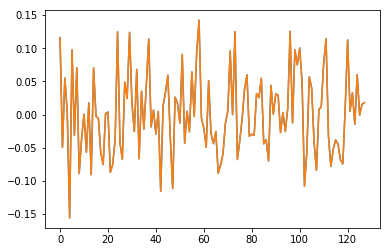

In [12]:
plt.plot(torch_embedding.detach().numpy()[0])
plt.plot(embedding.detach().numpy()[0])

In [13]:
res = call(ego_vel, embedding.detach().numpy(), iz, ir, ih, uz, ur, uh, bz, br, bh)[0]
expected = unittest_data_dict['lstm'][0][0].detach().numpy()

In [14]:
rnn_rs.shape

torch.Size([1, 128])

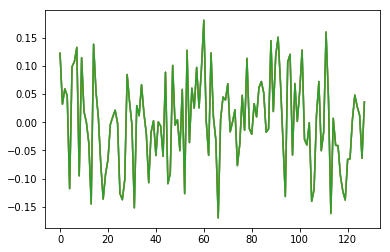

In [15]:
plt.plot(res)
plt.plot(expected)
plt.plot(rnn_rs[0].detach().numpy())